# Estimating the fraction of social media comments with a particular attribute

**Input:** datasets containing answers to "what do you think about a policy (e.g., gun control, abortion, etc)?"

## Data Format

|          |  X1  |  X2  | verified | lang | C(X) |
|----------|------|------|----------|------|------|
| answer 1 | 0.23 | 0.42 |    yes   |  en  | 0.37 |
| answer 2 | 0.12 | 0.60 |    no    |  en  | 0.21 |
| answer 3 | 0.45 | 0.86 |    no    |  es  | 0.89 |
|          |      |      |          |      |      |
| answer n | 0.56 | 0.92 |    yes   |  es  | 0.24 |

- **Task 1:** fraction of answers supporting a policy
- **Task 2:** fraction of answers making convincing arguments

In [1]:
from typing import Sequence, Dict
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.linear_model import LogisticRegression

from abc import ABC, abstractmethod
from IPython import display
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from util import DataHandler

In [3]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [4]:
positive_color = '#3d85c6'
negative_color = '#cc0000'
unknown_color = '#666666'

## 1. Load and profile the dataset

In [5]:
# base is a dataset of very large size.
base_dh = DataHandler('data/dataset1_base.csv')
# target is a dataset generated in a similar way with base, but at a different time period or another location.
target_dh = DataHandler('data/dataset1_target.csv')

In [6]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,UC(X),GT
0,0.324768,
1,0.362508,
2,0.064080,
3,0.071756,
4,0.485005,
...,...,...
999995,0.243103,
999996,0.096288,
999997,0.106021,
999998,0.272451,


In [7]:
#  .count_gt() function returns you the number of items with GT labels
base_dh.count_gt()

0

#### The Distribution of Classifier Scores
There is a theoretcial random variable representing the classifier scores C(X) for items randomly drawn from a distribution of item states X.

We plot the empirical density of C(X). With a large enough dataset, this is a good approximation of random variable's density function.

In our case, we are working with a *soft classifier* that always outputs scores between 0 and 1. Thus, we we get a continuous density plot.

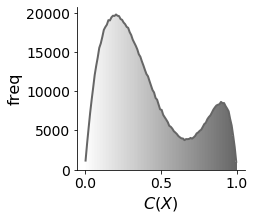

In [8]:
base_dh.plot_dist_classifier_scores(num_bin=100, title='base_dist_classifier_scores')

#### The Distribution of Ground Truth Labels
There is a theoretical random variable GT(X) representing the ground truth labels for items randomly drawn from the distribution of item states X. 

We plot the empirical density of GT(X). With a large enough dataset, this is a good approximation of random variable's density function.

In our case, Ground Truth is a binary label. (Note: for convenience, we will refer to the binary labels interchangeably as True/False, 1/0, and positive/negative). Thus, we we get a discrete density plot, a bar graph showing the frequency of each of the two ground truth labels. We normalize by the the total number of labels, so that the y-axis can be read off as P(GT).

In practice, we would not have access to Ground Truth labels for all items, since they are expensive to gather. That is the reason for wanting to use the classifier to do our prevalence estimation. But to aid in understanding how well we are predicting that prevalence, the ground truth labels for items are avaialble for our synthetic datasets through an oracle function.

In [9]:
# get GT labels for all items
base_dh.get_all_oracle()

In [10]:
base_dh.observed_df

,UC(X),GT
0,0.324768,False
1,0.362508,False
2,0.064080,False
3,0.071756,False
4,0.485005,False
...,...,...
999995,0.243103,False
999996,0.096288,False
999997,0.106021,False
999998,0.272451,False


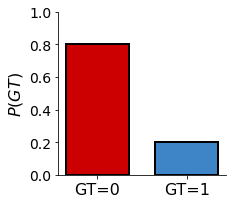

In [11]:
base_dh.plot_dist_gt_labels(title='base_dist_gt_labels')

## Representation of Joint Distribution

The classifier output can be used in prevalence estimation because we think classifier outputs are correlated with GT labels. The joint distribution between the two random variables C(X) and GT(X) tells us how they are related. Again, we will plot the empirical joint distribution as an approximation of the underlying theoretical joint distribution.

There are three different ways that we can represent a joint distribution in plots.

1) **JD Plot**: a colorized version of the classifier density plot.
  - For each C(x) value, the proportion of the density that is colored blue represents pr(GT=1 | C(x))

2) **classifier calibration curve** plus **classifier density plot**
  - In the calibration curve, the y-axis shows pr(GT=1 | C(x))

3) **class conditional density plots** plus **GT distribution**: 
  - a red plot shows the density of C(X) when GT is negative
  - a blue plot shows the density of C(X) when GT is positive
  - a bar graph shows the probability of GT+ and the probability of GT-

  
Given any one of these (sets of) plots, it would be possible to generate the other two, even if we didn't have the underlying empirical dataset.

To get from representation 2 to representation 1, we merely use the calibration curve to colorize each vertical slice of the classifier density plot.

To get from representation 2 to representation 3:
- for the GT distribution, we just integrate the area under the red and blue curves in the JD plot.
- for the positive density function, we extract just the red shaded region from the JD plot and renormalize the y-axis so that the total area adds up to 1. And similarly for the negative density function, using the red shaded area.

Note also that the GT plot that is part of representation 3 is exactly the thing that we are hoping to estimate: the ground truth prevalence. Thus, if we are able to get an estimate of the joint distribution in terms of the classifier density plot C(X) and the classifier calibration curve, we will have enough information to generate an estimate of GT.

##### 1) Single JD Plot

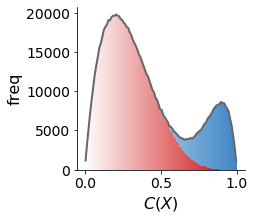

In [12]:
base_dh.plot_joint_dist(num_bin=100, title='base_stacked_frequency')

##### 2) **classifier calibration curve** plus **classifier density plot**

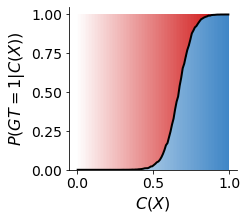

In [13]:
base_dh.plot_calibration_curve(num_bin=100, title='base_calibration_curve')

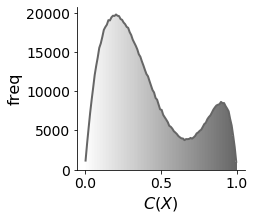

In [14]:
base_dh.plot_dist_classifier_scores(num_bin=100, title='base_dist_classifier_scores')

##### 3) **class conditional density plots** plus **GT distribution**:

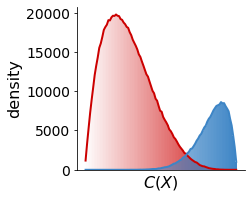

In [15]:
base_dh.plot_class_conditional_density(num_bin=100, title='base_class_conditional_density')

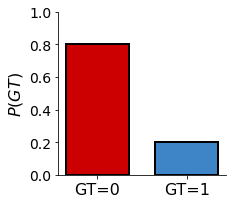

In [16]:
base_dh.plot_dist_gt_labels(title='base_dist_gt_labels')

## Naive Estimation Approach: Treat Classifier as Calibrated
One naive approach to prevalence estimation is called **probabilistic classify and count (PCC)**. To get an estimate of the number of GT positive labels in a dataset, just add up the clasifier outputs for all the items.

In the framework we are building up, that corresponds to assuming that the classifier is **calibrated**. A classifier is said to be calibrated if, for any classifier output C(x), of all items where it outputs that score, the fraction of items that have positive GT labels is exactly C(x). Foro example, when a classifier outputs 0.7, 70% of the time the item has a positive GT label.

If a classifier is calibrated, the calibration curve will be just a diagonal line with slope 1. We illustrate this below with the **ideal calibration curve**.

With classifier density plot and the assumed ideal calibration curve, we have representation 2 of the joint distribution. From that, we can integrate to get the relative size of the red and blue shaded areas in the joint distribution, and thus get GT. Indeed, summing up the classifier outputs for each of the items, as is done in the PCC approach, is just integrating to get the area of the red and blue shaded regions.


In [17]:
from util import DataHandler

In [18]:
base_dh = DataHandler('data/dataset1_base.csv')
target_dh = DataHandler('data/dataset1_target.csv')

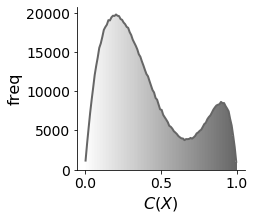

In [19]:
base_dh.plot_dist_classifier_scores(num_bin=100)

## Treat the classifier scores as calibrated scores

TKTK: we should adjust these functions slightly. I'd like to show that pcc is equivalent to assuming an ideal_calibration_curve and using that to generate an estimated version of representation 3, which includes a GT distribution.

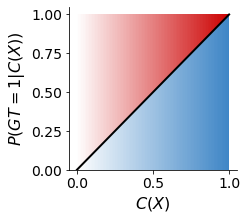

In [20]:
base_dh.plot_idea_calibration_curve(num_bin=100, title='calibrated_calibration_curve')

0.3952504

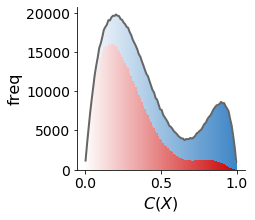

In [21]:
base_dh.get_pcc(num_bin=100)

##### Note the Wrong Estimate if Classifier is not Actually Calibrated
For this dataset, with access to the oracle telling us all the GT labels, we can see that the classifier's actual calibration curve was not the idealized one that PCC assumes.

And we can see that it produces an estimate prevalence of positive GT that is far from the true prevalence.

In [22]:
# get GT labels for all items
base_dh.get_all_oracle()

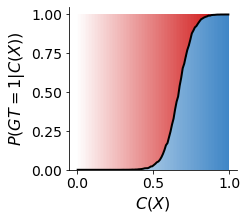

In [23]:
base_dh.plot_calibration_curve(num_bin=100)

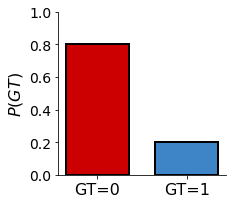

In [24]:
base_dh.plot_dist_gt_labels()

# Sec 2: Sensitivity of estimate to omitting calibration entirely

In [25]:
from util import DataHandler

In [26]:
base_dh = DataHandler('data/dataset1_base.csv')

In [27]:
base_dh.count_gt()

0

In [28]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')

In [29]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [30]:
base_dh.count_gt()

5000

In [31]:
base_dh.sample_df

,UC(X),GT
92,0.083335,False
160,0.225618,False
536,0.939350,True
770,0.243449,False
790,0.315738,False
...,...,...
999445,0.242344,False
999664,0.101156,False
999829,0.245853,False
999830,0.572854,False


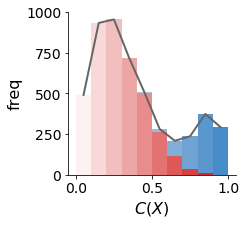

In [32]:
base_dh.plot_joint_dist(df=base_dh.sample_df)

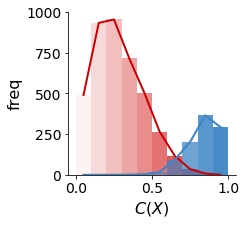

In [33]:
base_dh.plot_class_conditional_density(df=base_dh.sample_df)

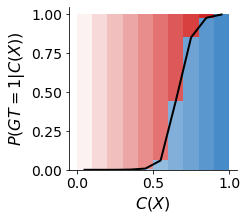

In [34]:
base_dh.plot_calibration_curve(df=base_dh.sample_df)

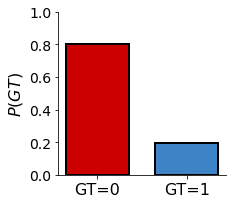

In [35]:
base_dh.plot_dist_gt_labels(df=base_dh.sample_df)

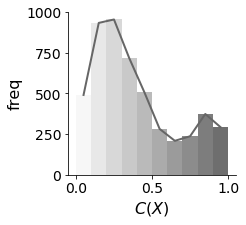

In [36]:
base_dh.plot_dist_classifier_scores(df=base_dh.sample_df)

## uniform on C(X)

In [37]:
base_dh = DataHandler('data/dataset1_base.csv')

In [38]:
base_dh.count_gt()

0

In [39]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [40]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [41]:
base_dh.count_gt()

5000

In [42]:
base_dh.sample_df

,UC(X),GT
0,0.324768,False
1,0.362508,False
2,0.064080,False
3,0.071756,False
4,0.485005,False
...,...,...
11908,0.627553,True
11917,0.659670,True
11950,0.632660,False
11957,0.688838,False


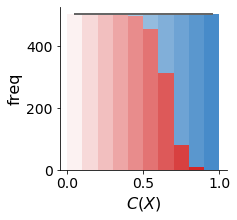

In [43]:
base_dh.plot_joint_dist(df=base_dh.sample_df, title='sample_stacked_frequency')

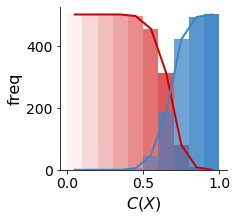

In [44]:
base_dh.plot_class_conditional_density(df=base_dh.sample_df)

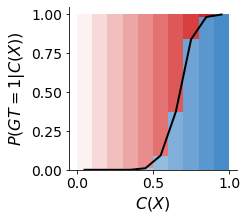

In [45]:
base_dh.plot_calibration_curve(df=base_dh.sample_df, title='sample_calibration_curve')

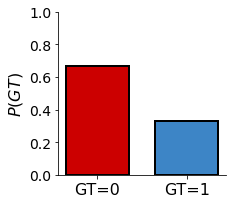

In [46]:
base_dh.plot_dist_gt_labels(df=base_dh.sample_df)

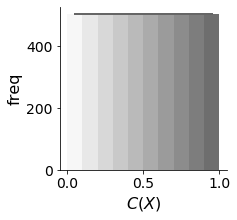

In [47]:
base_dh.plot_dist_classifier_scores(df=base_dh.sample_df)

In [48]:
base_dh.reset_oracle()

In [49]:
base_dh.count_gt()

0

In [50]:
base_dh.observed_df

,UC(X),GT
0,0.324768,
1,0.362508,
2,0.064080,
3,0.071756,
4,0.485005,
...,...,...
999995,0.243103,
999996,0.096288,
999997,0.106021,
999998,0.272451,


In [51]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [ ]:
base_dh.load_features(features=['has_url', 'lang'])

In [ ]:
base_dh.observed_df

# Let's first try some approaches

Given: classifier scores UC(X)

Target: P(GT=1)

## 1. Classify and Count (threshold = 0.5)

In [54]:
threshold = 0.5
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] > threshold].shape[0] / base_dh.size
est_p_cc

0.286299

In [55]:
base_dh._p_gt

0.2

## 2. Probabilistic Estimator

In [56]:
est_p_pe = base_dh.observed_df['UC(X)'].sum() / base_dh.size
est_p_pe

0.3952456016843302

In [57]:
base_dh._p_gt

0.2

# 3. Now assume we have some budget to label some data

In [ ]:
base_dh.count_gt()

In [ ]:
base_dh.size

In [ ]:
# let's label 20% data
num_sample = int(0.1 * base_dh.size)
num_sample

In [ ]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=num_sample, strategy='random')

In [ ]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [ ]:
base_dh.count_gt()

In [66]:
labeled_sample = base_dh.get_labeled_sample()

In [67]:
labeled_sample.shape

(5000, 2)

In [68]:
labeled_sample.loc[:, 'GT'] = labeled_sample['GT'].astype('bool')

/Users/siqiwu/Developments/env/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [69]:
labeled_sample

,UC(X),GT
0,0.324768,False
1,0.362508,False
2,0.064080,False
3,0.071756,False
4,0.485005,False
...,...,...
11908,0.627553,True
11917,0.659670,True
11950,0.632660,False
11957,0.688838,False


## 3.1 Learn the optimal threshold by F1

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

In [ ]:
roc_auc_score(labeled_sample['GT'].values, labeled_sample['UC(X)'].values)

In [ ]:
labeled_sample['UC(X)'].map(lambda x: True if x > 0.3 else False).values

In [ ]:
best_threshold = 0
best_f1 = 0

for thres in np.linspace(0, 1, 101):
    f1 = f1_score(labeled_sample['GT'].values,
             labeled_sample['UC(X)'].map(lambda x: True if x >= thres else False).values)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thres

best_threshold, best_f1

## with the best threshold

In [ ]:
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] >= best_threshold].shape[0] / base_dh.size
est_p_cc

## 3.2 learn a platt scaling function

In [73]:
labeled_sample

,UC(X),GT
0,0.324768,False
1,0.362508,False
2,0.064080,False
3,0.071756,False
4,0.485005,False
...,...,...
11908,0.627553,True
11917,0.659670,True
11950,0.632660,False
11957,0.688838,False


In [74]:
train_UCX = labeled_sample['UC(X)'].values.reshape(-1, 1)
train_GT = labeled_sample['GT'].values
prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_UCX, train_GT)

/Users/siqiwu/Developments/env/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/Users/siqiwu/Developments/GitWorks/prevalence-estimation-tutorial/code/util.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GT'] = df['GT'].astype('bool')
/Users/siqiwu/Developments/env/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


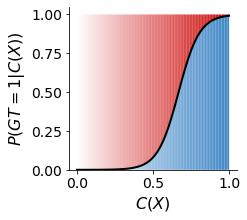

In [48]:
base_dh.plot_calibration_curve(df=base_dh.sample_df, num_bin=100, method='platt scaling', title='sample_calibration_curve')

In [49]:
labeled_sample = base_dh.get_labeled_sample()
items = [(cx, gt) for cx, gt in zip(labeled_sample['UC(X)'].values, labeled_sample['GT'].values)]
num_sample = len(items)

In [50]:
# bootstrap for CI
num_bootstrap = 1000
results = np.zeros((num_bootstrap, 101))
est_result_list = []
target_results = np.zeros((num_bootstrap, 101))
target_result_list = []

In [51]:
empir_cx_axis = np.linspace(0, 1, 101)
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    bootstrapped_prob_cali_func = LogisticRegression(solver='lbfgs', fit_intercept=True).fit(bootstrapped_train_UCX, bootstrapped_train_GT)
    bootstrapped_prob_cali_curve = bootstrapped_prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
    results[idx, :] = bootstrapped_prob_cali_curve.reshape(1, -1)
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    est_result_list.append(est_pcc)    
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    target_result_list.append(est_pcc) 

In [52]:
results

array([[2.65305207e-05, 3.10624686e-05, 3.63685365e-05, ...,
        9.92741498e-01, 9.93793954e-01, 9.94694623e-01],
       [3.18025522e-05, 3.71333743e-05, 4.33577231e-05, ...,
        9.92089408e-01, 9.93217376e-01, 9.94185451e-01],
       [3.60161718e-05, 4.19703000e-05, 4.89087057e-05, ...,
        9.91528211e-01, 9.92721359e-01, 9.93747526e-01],
       ...,
       [2.55898004e-05, 2.99645763e-05, 3.50872279e-05, ...,
        9.92562076e-01, 9.93641122e-01, 9.94564484e-01],
       [3.03797470e-05, 3.54961040e-05, 4.14740885e-05, ...,
        9.92249225e-01, 9.93359025e-01, 9.94310828e-01],
       [3.62907586e-05, 4.22530374e-05, 4.91948222e-05, ...,
        9.90840469e-01, 9.92122825e-01, 9.93226876e-01]])

In [53]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

(0.19947662040230607, 0.19597260768684063, 0.20267404593505112)

In [54]:
target_dh._p_gt

0.7

In [55]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

(0.6116631435293325, 0.6049627142702947, 0.6176823037701771)

In [56]:
results.shape

(1000, 101)

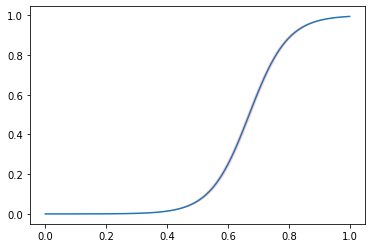

In [57]:
empir_cx_axis = np.linspace(0, 1, 101)

mediaum_prob_cali_curve = np.median(results, axis=0)
lower_prob_cali_curve = np.percentile(results, q=2.5, axis=0)
upper_prob_cali_curve = np.percentile(results, q=97.5, axis=0)

plt.plot(empir_cx_axis, mediaum_prob_cali_curve)
plt.fill_between(empir_cx_axis, lower_prob_cali_curve, upper_prob_cali_curve, facecolor='r', alpha=0.2)

In [65]:
cali_prob_scores = prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

NameError: name 'prob_cali_func' is not defined

In [ ]:
cali_prob_scores.sum() / len(cali_prob_scores)

## 3.3 learn the class-conditional density function

In [64]:
# bootstrap for CI
num_bootstrap = 100
pos_results = np.zeros((num_bootstrap, 10))
neg_results = np.zeros((num_bootstrap, 10))

est_result_list = []
target_result_list = []

In [65]:
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    
    obs_freq, _ = np.histogram(bootstrapped_train_UCX, bins=np.linspace(0, 1, 11))
    pos_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == True], bins=np.linspace(0, 1, 11))
    neg_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == False], bins=np.linspace(0, 1, 11))
    
    obs_freq = obs_freq / obs_freq.sum()
    pos_freq = pos_freq / pos_freq.sum()
    neg_freq = neg_freq / neg_freq.sum()
    
    pos_results[idx, :] = pos_freq
    neg_results[idx, :] = neg_freq
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p
    
    est_result_list.append(best_p_p)
    
    target_obs_freq, _ = np.histogram(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))
    target_obs_freq = target_obs_freq / target_obs_freq.sum()
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p

    target_result_list.append(best_p_p)    

In [66]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

(0.33, 0.32, 0.34)

In [67]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

(0.68, 0.68, 0.6900000000000001)

In [68]:
target_dh._p_gt

0.7

(array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

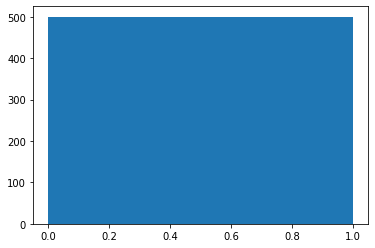

In [69]:
plt.hist(labeled_sample['UC(X)'].values, bins=np.linspace(0, 1, 11))

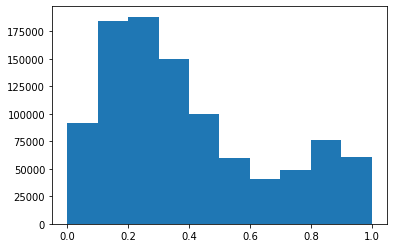

In [70]:
obs_freq, _, _ = plt.hist(base_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [71]:
obs_freq /= obs_freq.sum()

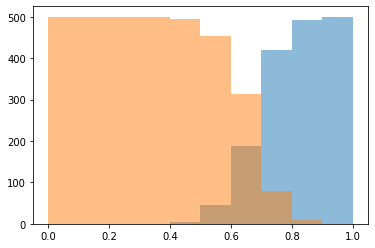

In [72]:
pos_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == True]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)
neg_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == False]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)

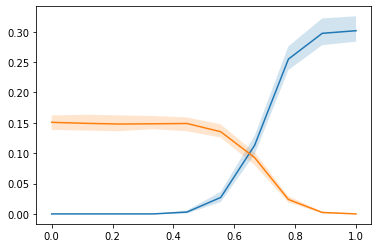

In [73]:
mediaum_pos_density = np.median(pos_results, axis=0)
lower_pos_density = np.percentile(pos_results, q=2.5, axis=0)
upper_pos_density = np.percentile(pos_results, q=97.5, axis=0)

mediaum_neg_density = np.median(neg_results, axis=0)
lower_neg_density = np.percentile(neg_results, q=2.5, axis=0)
upper_neg_density = np.percentile(neg_results, q=97.5, axis=0)

empir_cx_axis = np.linspace(0, 1, 10)

plt.plot(empir_cx_axis, mediaum_pos_density)
plt.fill_between(empir_cx_axis, lower_pos_density, upper_pos_density, alpha=0.2)

plt.plot(empir_cx_axis, mediaum_neg_density)
plt.fill_between(empir_cx_axis, lower_neg_density, upper_neg_density, alpha=0.2)

In [ ]:
pos_freq /= pos_freq.sum()
neg_freq /= neg_freq.sum()

In [ ]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [ ]:
min_dist = 100
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [ ]:
best_p_p, min_dist

# 4. estimate for the target period

## 4.1 PCC

In [ ]:
target_cali_prob_scores = prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [ ]:
target_cali_prob_scores.sum() / len(target_cali_prob_scores)

## 4.2 MM

In [ ]:
target_obs_freq, _, _ = plt.hist(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [ ]:
min_dist = 10000
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [ ]:
best_p_p, min_dist

# Target

In [58]:
target_dh = DataHandler('data/dataset1_target.csv')

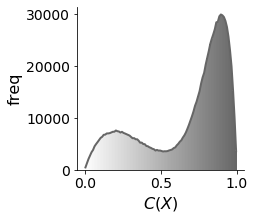

In [59]:
target_dh.plot_dist_classifier_scores(num_bin=100, title='target_dist_classifier_scores')

In [60]:
median_calibration_curve = np.median(results, axis=0)

/Users/siqiwu/Developments/GitWorks/prevalence-estimation-tutorial/code/util.py:370: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if calibration_curve == 'ideal':


0.60648228096624

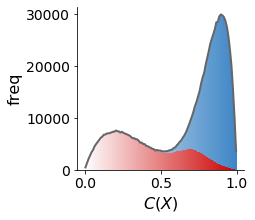

In [61]:
target_dh.get_pcc(num_bin=100, calibration_curve=median_calibration_curve, title='target_pcc_stacked_frequency')

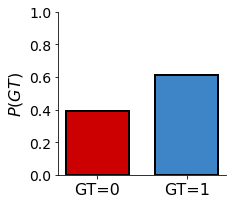

In [63]:
target_dh.plot_dist_gt_labels(set_pp=True, p_p=np.median(target_result_list), title='target_pcc_dist_gt_labels')